In [12]:
# Jupter notebook magic
%matplotlib inline

# Import libraries to work with the data
import os
import sys
sys.path.append('../../scripts')

from branca.colormap import linear
import folium

import geopandas as gpd
from geopandas import GeoDataFrame

import h5py
import numpy as np
import pandas as pd
import pyepsg
import scipy.optimize
from shapely.geometry import (Polygon, Point, box)
import xarray as xr
import regionmask

from GRACE_MASCON.pygrace import (extract_grace, get_mascon_gdf, get_cmwe_trend_analysis)

In [2]:
fname = 'c:\work\datadrive\GRACE\GSFC.glb.200301_201607_v02.3b-ICE6G.h5'
# fname = '/att/nobackup/aarendt/GRACE/GSFC.glb.200301_201607_v02.3b-ICE6G.h5'

In [3]:
fpath = os.path.join(os.path.abspath(os.path.curdir), fname)

f = extract_grace(fpath)

In [5]:
mascon = f['mascon']

In [7]:
mascon_gdf = get_mascon_gdf(mascon)

There are 41168 Mascons in this dataset.


In [8]:
## we need to track mascon numbers later, which we get from the index, so make a new "mascon" column
mascon_gdf['mascon'] = mascon_gdf.index

## read in the natural Earth dataset

In [9]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

## build a polygon representing HMA bounding box

In [9]:
coordinates = [(62,26), (62,46), (106,46), (106, 26)]
# Create a Shapely polygon from the coordinate-tuple list
poly = Polygon(coordinates)
# create a geodataframe
HMA_region = gpd.GeoDataFrame()
HMA_region.loc[0, 'geometry'] = poly

### bring in the LIS data

In [15]:
fname = 'c:\work\datadrive\LIS\evapMonthly.nc'
# fname = '/att/nobackup/aarendt/snowmeltMonthly.nc'

In [17]:
ds = xr.open_dataset(fname)

### subset for later testing

In [31]:
subset = data['Evap_tavg'].isel(time=0)
# data['Qsm_tavg'].isel(time=0)

### Or we can build a polygon around the xarray object

In [19]:
minLong = ds.coords['longitude'].min().values
maxLong = ds.coords['longitude'].max().values
minLat = ds.coords['latitude'].min().values
maxLat = ds.coords['latitude'].max().values

coordinates = [(minLong,minLat), (minLong,maxLat), (maxLong,maxLat), (maxLong, minLat)]
# Create a Shapely polygon from the coordinate-tuple list
poly = Polygon(coordinates)
# create a geodataframe
HMA_region = gpd.GeoDataFrame()
HMA_region.loc[0, 'geometry'] = poly

../../scripts\GRACE_MASCON\pygrace.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  mascon_gdf['avg_mass_change_cm'] = avg_mass


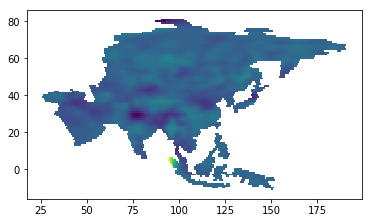

In [20]:
# HMA
HMA = mascon_gdf[(mascon_gdf['location'] == 80.0) & ((mascon_gdf['basin'] > 5000.0) & (mascon_gdf['basin'] < 6100.0))]
HMA_w_trend = get_cmwe_trend_analysis(HMA, f)
HMA_w_trend.plot(column='avg_mass_change_cm')

### Select only those mascons in the HMA bounding box

In [21]:
gpd_intersect = gpd.overlay(HMA_region, HMA_w_trend, how='intersection')

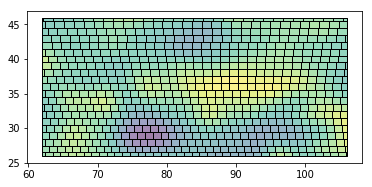

In [39]:
gpd_intersect.plot(column='avg_mass_change_cm')

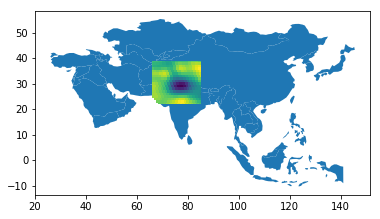

In [22]:
gpd_intersect.plot(column='avg_mass_change_cm', ax=world[world['continent'] == 'Asia'].plot(), figsize=(20, 20));

In [37]:
import regionmask

numbers = gpd_intersect.index.values
names = gpd_intersect['mascon'].values
abbrevs = gpd_intersect['mascon'].values
m = regionmask.Regions_cls('HMA_msk',numbers,names,abbrevs,gpd_intersect.geometry.values)

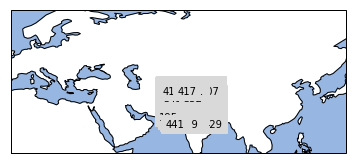

In [27]:
ax = m.plot()
import cartopy.crs as ccrs
ax.set_extent([0, 140, 10, 70], crs = ccrs.PlateCarree());

In [32]:
m2 = m.mask(subset, lon_name = 'longitude', lat_name = 'latitude')
print('All NaN? ', np.all(np.isnan(m2)))

All NaN?  False


In [33]:
m2

<xarray.DataArray (north_south: 1696, east_west: 1896)>
array([[  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,  429.,  429.,   nan],
       [  nan,   nan,   nan, ...,  429.,  429.,   nan],
       ..., 
       [  nan,  228.,  228., ...,  249.,  249.,   nan],
       [  nan,  228.,  228., ...,  249.,  249.,   nan],
       [  nan,  228.,  228., ...,  249.,  249.,   nan]])
Coordinates:
  * north_south  (north_south) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
  * east_west    (east_west) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
    latitude     (north_south, east_west) float64 22.02 22.02 22.02 22.02 ...
    longitude    (north_south, east_west) float64 66.03 66.04 66.05 66.06 ...

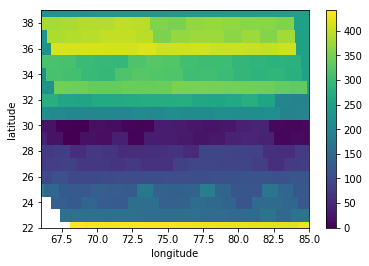

In [34]:
m2.plot(x='longitude',y='latitude')

<xarray.DataArray ()>
array(0.0)

In [35]:
subset.where(m2 == 100).max()

<xarray.DataArray ()>
array(6.151000206955359e-05)
Coordinates:
    time     datetime64[ns] 2001-01-01

In [ ]:
plt.figure(figsize=(7,4));
ax = plt.axes(projection = ccrs.PlateCarree());
subset.plot.pcolormesh(ax=ax, transform = ccrs.PlateCarree(), x='longitude', y='latitude');
ax.coastlines();
ax.set_extent([0, 140, 10, 70], crs = ccrs.PlateCarree());